# Initialization
---
- example data (Heidi 2003 data, 1 day Synechococcus)

In [1]:
library(R.matlab)
library(seewave) # Kullback-Leibler 
library(DEoptim)
library(cmaes) 
library(cmaesr) 

df <- readMat("SYN_data/day733320data.mat") # load 1 day of observed Synechococcus size distribution (from SOSIK et al. 2003)

time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) 
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))


results <- readMat("SYN_data/results.mat") # load results (from SOSIK et al. 2003)
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

resol <- 10
dt <- resol/60
time.interval <- median(diff(as.numeric(colnames(V.hists))))
ti <- as.numeric(colnames(V.hists))

# create Light data with 'dt' time interval.
seq <- NULL
    for(i in 1:(length(ti)-1)){
		s <- seq(ti[i], ti[i+1], length.out=1/dt)
		seq <- c(seq, s)
		}
ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
Einterp <- ep$y
Einterp[Einterp < 0] <- 0

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.


Attaching package: 'R.matlab'


The following objects are masked from 'package:base':

    getOption, isOpen


Loading required package: parallel


DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich


Loading required package: ParamHelpers

Loading required package: BBmisc


Attaching package: 'BBmisc'


The following object is masked from 'package:base':

    isFALSE


Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package:seewave':

    wf


Loading required package: smoof

Warning message in readMat("SYN_data/day733320data.mat"):
"strings not representable in native encoding will be translated to UTF-8"
Warning message in readMat("SYN_data/day733320data.mat"):
"input string '<80>' cannot be 

- Load matrix model

In [3]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
        resp <-  rep(0, length(y)) # proportion of carbon storage to total carbon

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 1 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
    	stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

- $Sigma$ function for sum of squared residuals


In [4]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
        
                gmax <- as.numeric(params[1]) 
                dmax <- as.numeric(params[2]) / 10
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler distance

In [5]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
            
                 gmax <- as.numeric(params[1]) 
                dmax <- as.numeric(params[2]) / 10
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
                    }
			sigma <- sum(sigma, na.rm=T) * 10
			return(sigma)

}


- $Sigma$ function for Huber loss

In [6]:
###############
## sigma.hl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# using Hubert Loss (1954) approach.

	.sigma.hl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
           
                gmax <- as.numeric(params[1]) 
                dmax <- as.numeric(params[2]) / 10
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

        delta <- 1.345
			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
                    # Huber loss calculation
                    a <- N.dist[, hr+1] - round(TotN[hr+1]*wt.norm,1)
                    loss <- ifelse(abs(a) <= delta,
                                       0.5 * a^2,
                                       delta * (abs(a) - 0.5 * delta))
                    sigma[,hr] <- mean(loss)
                    }
            sigma <- sum(sigma)/100 ## HUBER loss

			return(sigma)

}

# 1. Objective functions
---

- ### sum of squared residuals 
$$
Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2

In [6]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax <- as.numeric(params[1]) 
        dmax <- as.numeric(params[2]) / 10
        b <- as.numeric(params[3]) * 10
        E_star <- as.numeric(params[4]) * 1000
		resnorm <- opt$optim$bestval


Iteration: 10 bestvalit: 5.517286 bestmemit:    0.176830    0.440282    0.495687    0.350153
Iteration: 20 bestvalit: 5.067552 bestmemit:    0.152287    0.386790    0.429580    0.184279
Iteration: 30 bestvalit: 4.983625 bestmemit:    0.167943    0.382562    0.408546    0.255142
Iteration: 40 bestvalit: 4.983041 bestmemit:    0.172304    0.381869    0.409788    0.253870
Iteration: 50 bestvalit: 4.977128 bestmemit:    0.167859    0.370345    0.403475    0.249753
Iteration: 60 bestvalit: 4.975069 bestmemit:    0.165957    0.362826    0.406310    0.258016
Iteration: 70 bestvalit: 4.974375 bestmemit:    0.167277    0.368703    0.405154    0.254233
Iteration: 80 bestvalit: 4.974375 bestmemit:    0.167277    0.368703    0.405154    0.254233
Iteration: 90 bestvalit: 4.974375 bestmemit:    0.167290    0.368703    0.405154    0.254233
Iteration: 100 bestvalit: 4.974375 bestmemit:    0.167290    0.368703    0.405154    0.254233
Iteration: 110 bestvalit: 4.974375 bestmemit:    0.167290    0.368703

- ### Kullback-Leibler divergence
$$
Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [7]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax. <- as.numeric(params[1]) 
        dmax. <- as.numeric(params[2]) / 10
        b. <- as.numeric(params[3]) * 10
        E_star. <- as.numeric(params[4]) * 1000
		resnorm. <- opt$optim$bestval


Iteration: 10 bestvalit: 2.316946 bestmemit:    0.174614    0.310191    0.391888    0.258103
Iteration: 20 bestvalit: 2.311947 bestmemit:    0.171838    0.310191    0.391888    0.267332
Iteration: 30 bestvalit: 2.304819 bestmemit:    0.174520    0.330042    0.395668    0.252934
Iteration: 40 bestvalit: 2.302726 bestmemit:    0.170109    0.311909    0.387757    0.253853
Iteration: 50 bestvalit: 2.300399 bestmemit:    0.173456    0.326112    0.386372    0.258825
Iteration: 60 bestvalit: 2.299717 bestmemit:    0.171226    0.326733    0.387333    0.258934
Iteration: 70 bestvalit: 2.298874 bestmemit:    0.169244    0.316707    0.388854    0.259896
Iteration: 80 bestvalit: 2.298733 bestmemit:    0.168978    0.316707    0.388854    0.259896
Iteration: 90 bestvalit: 2.298218 bestmemit:    0.170080    0.320984    0.386325    0.259364
Iteration: 100 bestvalit: 2.298218 bestmemit:    0.170080    0.320984    0.386325    0.259364
Iteration: 110 bestvalit: 2.297861 bestmemit:    0.170424    0.316697

- ### Huber loss 
$$
L =\begin{cases}
\frac12(y - \hat{y})^2 & for |y - \hat{y}| \leq d\\
d|y - \hat{y}| - \frac12 d^2 & otherwise
\end{cases}
$$


In [19]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax.. <- as.numeric(params[1]) 
        dmax.. <- as.numeric(params[2]) / 10
        b.. <- as.numeric(params[3]) * 10
        E_star.. <- as.numeric(params[4]) * 1000
		resnorm.. <- opt$optim$bestval

Iteration: 10 bestvalit: 6.741640 bestmemit:    0.173422    0.318218    0.376251    0.279075
Iteration: 20 bestvalit: 6.741640 bestmemit:    0.173422    0.318218    0.376251    0.279075
Iteration: 30 bestvalit: 6.724315 bestmemit:    0.170555    0.340880    0.406975    0.249521
Iteration: 40 bestvalit: 6.716809 bestmemit:    0.169948    0.337542    0.386808    0.258564
Iteration: 50 bestvalit: 6.716165 bestmemit:    0.173179    0.353297    0.391267    0.250077
Iteration: 60 bestvalit: 6.715578 bestmemit:    0.171770    0.348056    0.387332    0.254561
Iteration: 70 bestvalit: 6.715578 bestmemit:    0.171770    0.348056    0.387332    0.254561
Iteration: 80 bestvalit: 6.715578 bestmemit:    0.171770    0.348056    0.387332    0.254561
Iteration: 90 bestvalit: 6.715578 bestmemit:    0.171770    0.348056    0.387332    0.254561
Iteration: 100 bestvalit: 6.715578 bestmemit:    0.171770    0.348056    0.387332    0.254561
Iteration: 110 bestvalit: 6.715501 bestmemit:    0.171715    0.344515

##  Results

In [9]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- Vproj.. <-V.hists
Nproj <- Nproj. <- Nproj.. <- N.dist
mu_N <- mu_N. <- mu_N.. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star., resol=resol)
      Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
      Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
	    Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
		mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
					    ((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
          		    
      B.. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax.., dmax=dmax..,b=b.., E_star=E_star.., resol=resol)
      Nproj..[,hr+1] <- round(B.. %*% Nproj..[,hr]) # calculate numbers of individuals
      Vproj..[,hr+1] <- B.. %*% Vproj..[,hr] # calculate the projected size-frequency distribution
	    Vproj..[,hr+1] <- Vproj..[,hr+1]/sum(Vproj..[,hr+1]) # normalize distribution so sum = 1
		mu_N..[,hr+1] <- log(sum(Nproj..[,hr+1])/sum(Nproj..[,hr]))/
					    ((as.numeric(colnames(Nproj..)[hr+1])-as.numeric(colnames(Nproj..)[hr]))/(time.interval))
				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)
Nproj. <- colSums(Nproj.)
colnames(mu_N.) <- colnames(Vproj.)
Nproj.. <- colSums(Nproj..)
colnames(mu_N..) <- colnames(Vproj..)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)
d.mu_N.. <- 24*mean(mu_N..[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2),"-",round(d.mu_N.,2),"-",round(d.mu_N..,2)))

[1] "daily growth rate= 0.74 - 0.72 - 0.76"


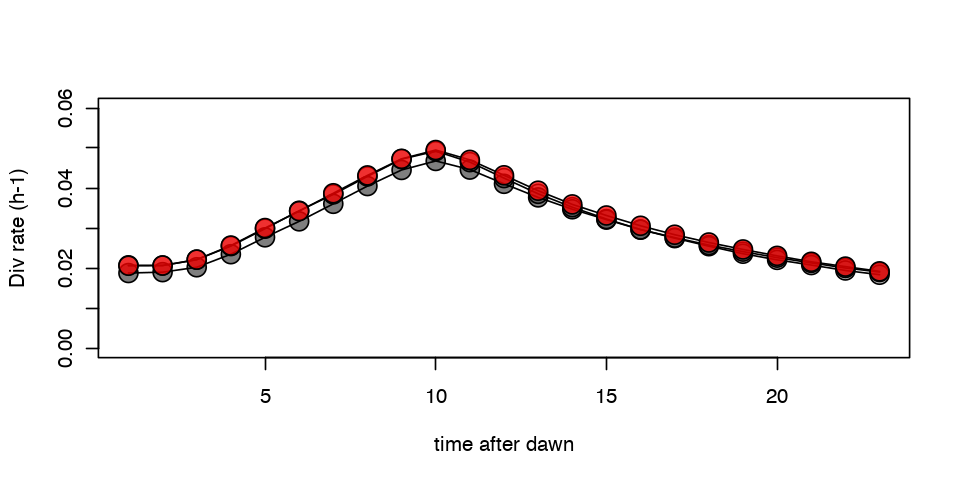

In [10]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
    points(mu_N..[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.75))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

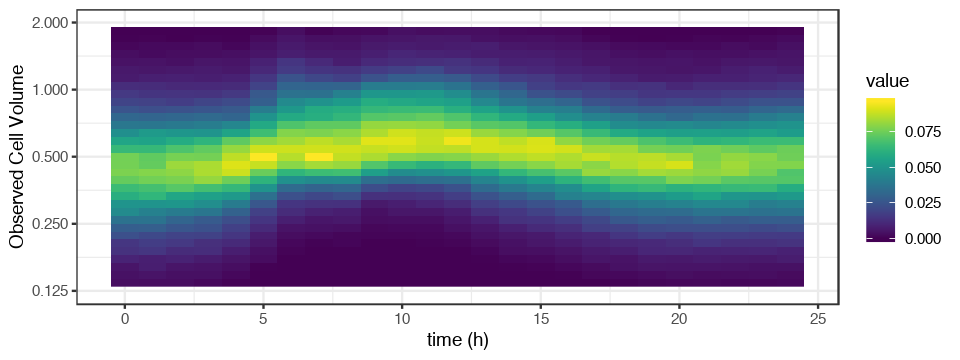

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

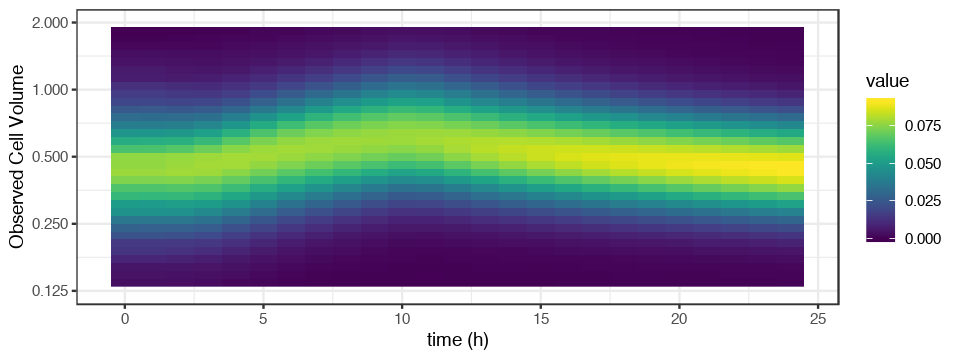

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

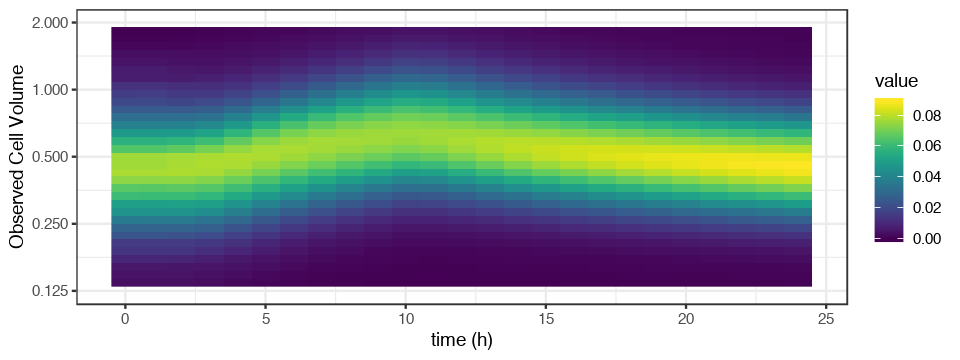

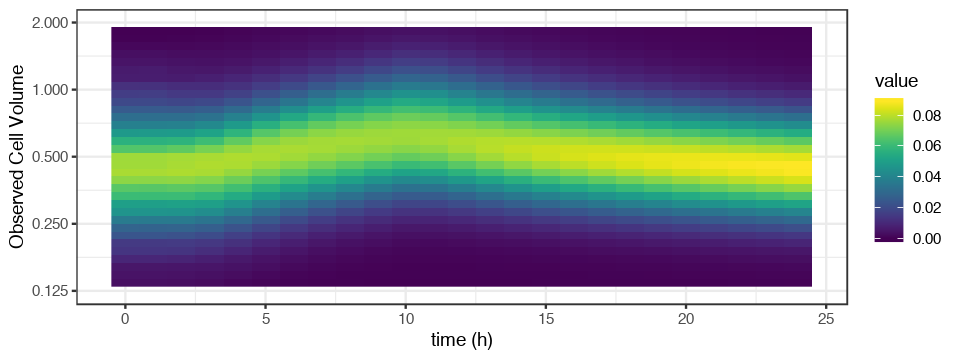

In [11]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

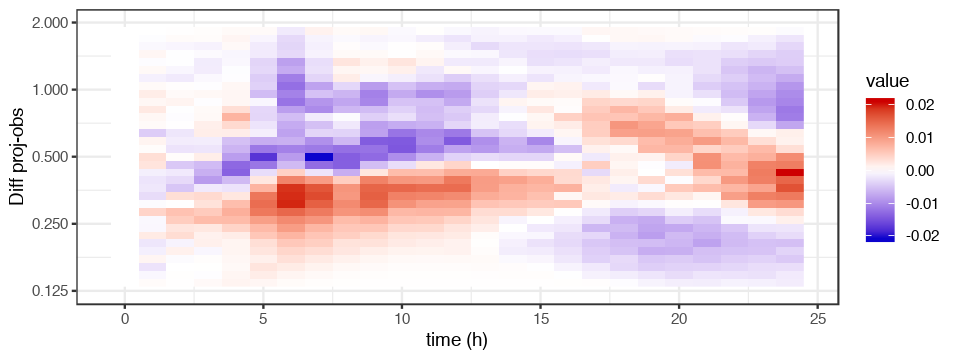

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

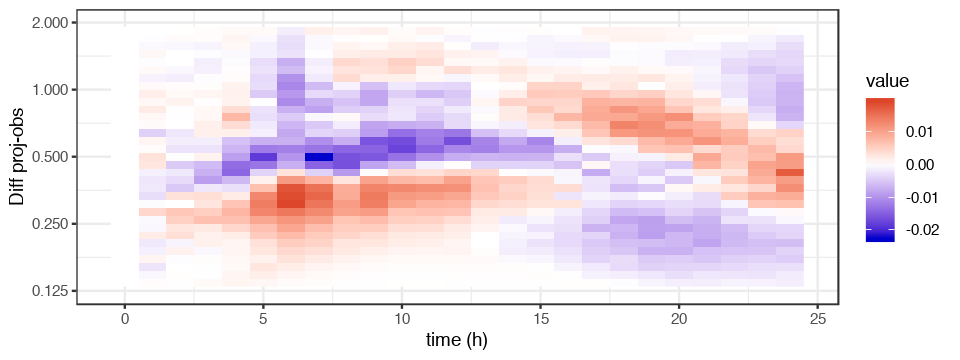

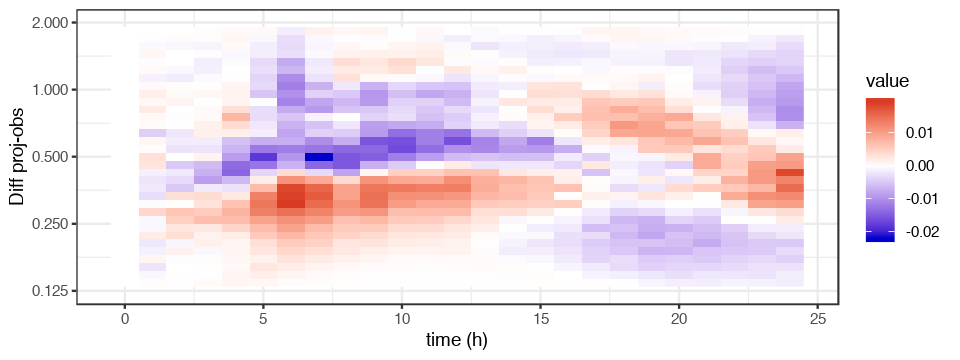

In [12]:
ggplot(melt(Vproj-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj.-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj..-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 2. Objective functions
---

- ### Differential evolution

In [58]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax.. <- as.numeric(params[1]) 
        dmax.. <- as.numeric(params[2]) / 10
        b.. <- as.numeric(params[3]) * 10
        E_star.. <- as.numeric(params[4]) * 1000
		resnorm.. <- opt$optim$bestval

ERROR: Error in checkForRemoteErrors(val): 16 nodes produced errors; first error: could not find function ".sigma.hl"


- ### Covariance matrix adapting evolutionary strategy (cmaes package)

In [14]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)
    
    opt <- cma_es(par=c(0.5,0.5,0.5,0.5),f, lower=c(0,0,0,0), upper=c(1,1,1,1))#, control=list(diag.pop=TRUE))
 		params <- opt$par
        gmax... <- as.numeric(params[1]) 
        dmax... <- as.numeric(params[2]) / 10
        b... <- as.numeric(params[3]) * 10
        E_star... <- as.numeric(params[4]) * 1000
		resnorm... <- opt$value
print(params)

[1] 0.3845517 0.3120301 0.3956539 0.9124316


In [59]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)
    
    opt <- cma_es(par=c(0.5,0.5,0.5,0.5),f, 
                  lower=c(0,0,0,0),   
                  upper=c(1,1,1,2), 
                  control=list(stopfitness= 1e-6, 
                               maxit=1000)
                 )
 		params <- opt$par
        gmax... <- as.numeric(params[1]) 
        dmax... <- as.numeric(params[2]) / 10
        b... <- as.numeric(params[3]) * 10
        E_star... <- as.numeric(params[4]) * 1000
		resnorm... <- opt$value
print(params)

[1] 0.7187165 0.3116424 0.3955932 1.7096244


In [54]:
print(resnorm...)

[1] 7.130577


##  Results

In [56]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj.. <- Vproj... <-V.hists
Nproj.. <- Nproj... <- N.dist
mu_N.. <- mu_N... <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax.., dmax=dmax..,b=b.., E_star=E_star.., resol=resol)
        Nproj..[,hr+1] <- round(B %*% Nproj..[,hr]) # calculate numbers of individuals
	    Vproj..[,hr+1] <- B %*% Vproj..[,hr] # calculate the projected size-frequency distribution
		Vproj..[,hr+1] <- Vproj..[,hr+1]/sum(Vproj..[,hr+1]) # normalize distribution so sum = 1
		mu_N..[,hr+1] <- log(sum(Nproj..[,hr+1])/sum(Nproj..[,hr]))/
					    ((as.numeric(colnames(Nproj..)[hr+1])-as.numeric(colnames(Nproj..)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax..., dmax=dmax...,b=b..., E_star=E_star..., resol=resol)
      Nproj...[,hr+1] <- round(B. %*% Nproj...[,hr]) # calculate numbers of individuals
      Vproj...[,hr+1] <- B. %*% Vproj...[,hr] # calculate the projected size-frequency distribution
	    Vproj...[,hr+1] <- Vproj...[,hr+1]/sum(Vproj...[,hr+1]) # normalize distribution so sum = 1
		mu_N...[,hr+1] <- log(sum(Nproj...[,hr+1])/sum(Nproj...[,hr]))/
					    ((as.numeric(colnames(Nproj...)[hr+1])-as.numeric(colnames(Nproj...)[hr]))/(time.interval))				
    }

Nproj.. <- colSums(Nproj..)
colnames(mu_N..) <- colnames(Vproj..)
Nproj... <- colSums(Nproj...)
colnames(mu_N...) <- colnames(Vproj...)
#############################
## Growth rate calculation ##
#############################
d.mu_N.. <- 24*mean(mu_N..[-c(1:2)], na.rm=T)
d.mu_N... <- 24*mean(mu_N...[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N..,2),"-",round(d.mu_N...,2)))

[1] "daily growth rate= 0.76 - 0.68"


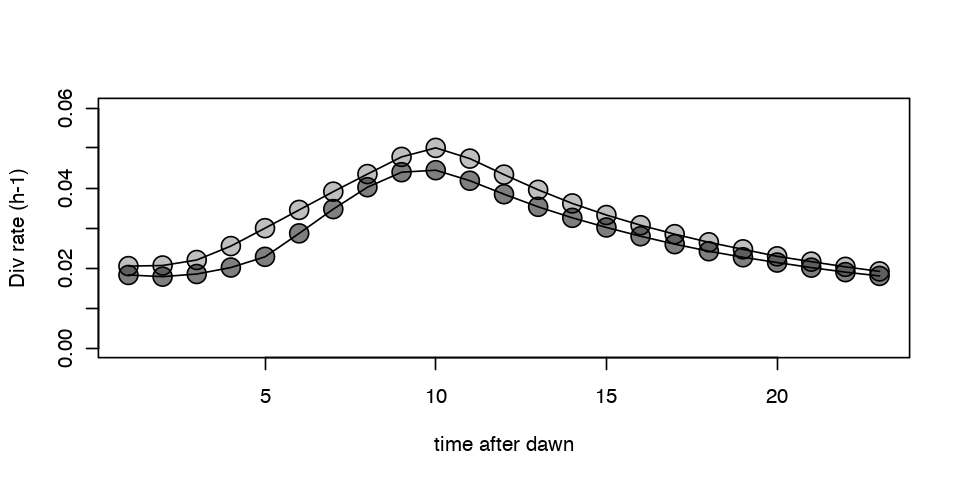

In [57]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N..[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N...[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))


Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

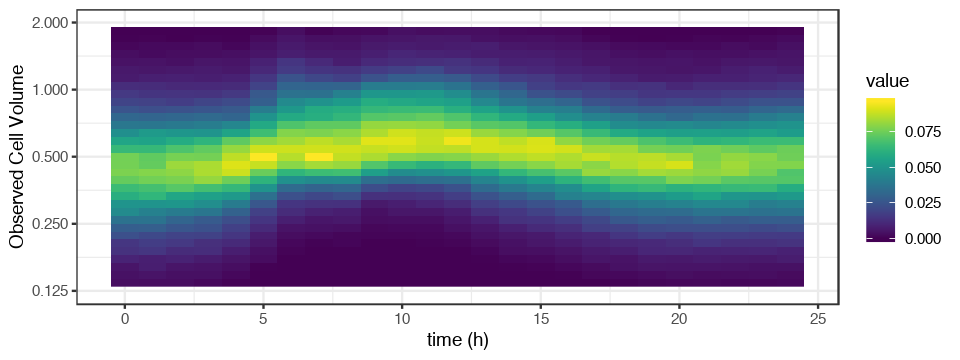

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

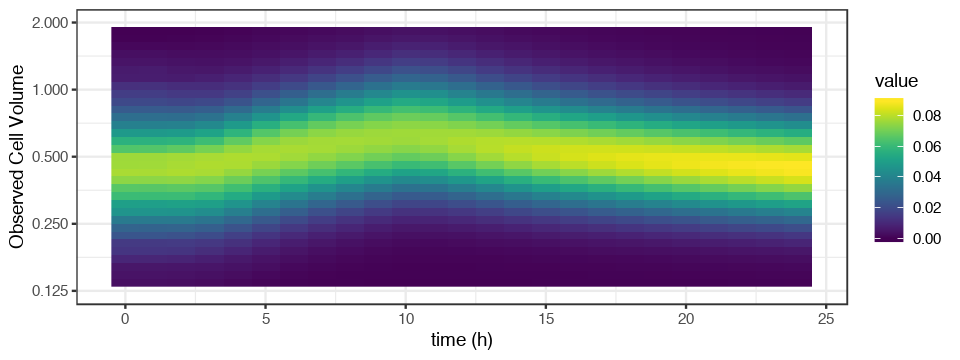

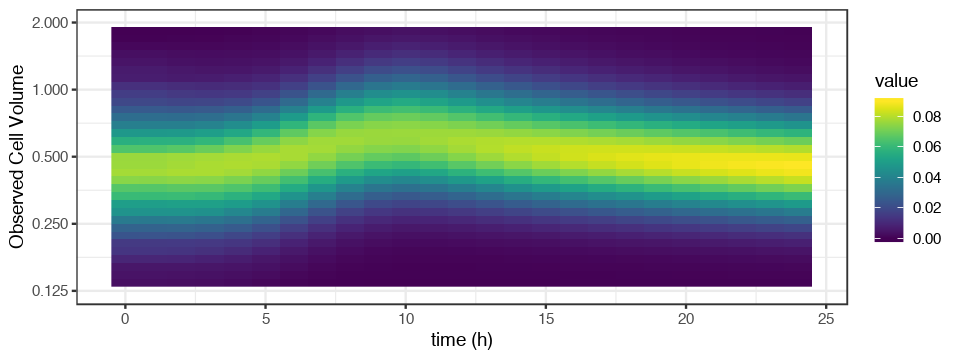

In [17]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj...), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

[1] 0.002226472


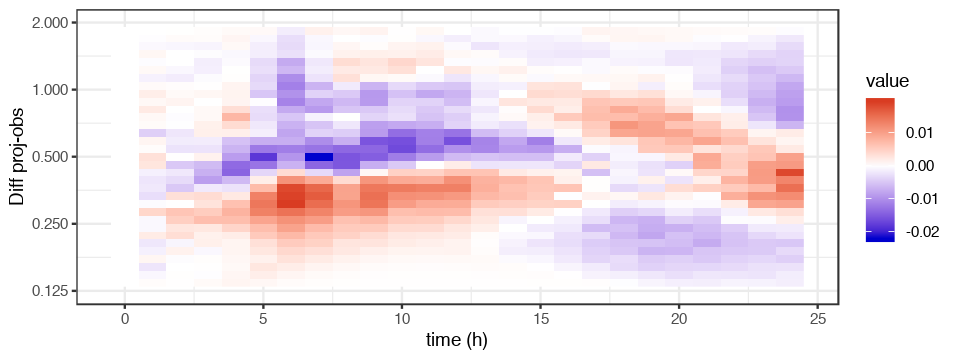

[1] 0.002431654


Warning message:
"Removed 600 rows containing missing values (geom_raster)."

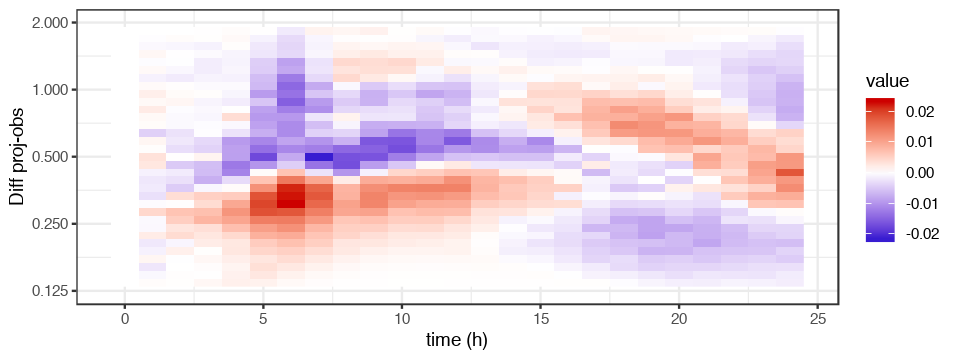

[1] 0.0004953654


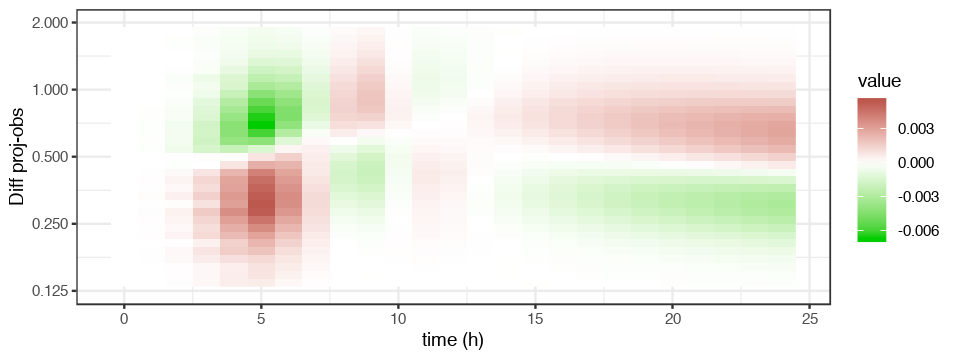

In [18]:
ggplot(melt(Vproj..-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
print(mean(abs(Vproj..-V.hists)))

ggplot(melt(Vproj...-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
print(mean(abs(Vproj...-V.hists)))

ggplot(melt(Vproj...-Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='green3',high='brown', midpoint=0)
print(mean(abs(Vproj...-Vproj..)))